# <a id='toc1_'></a>[This is the shortest verison of DMA, just want to show](#toc0_)

In [1]:
# This is only here to direct python to find where the 
# Mark Ruihe change 
import sys  ; import pybamm; import os
str_path_0 = os.path.abspath(os.path.join(pybamm.__path__[0],'..'))
str_path_1 = os.path.abspath(os.path.join(str_path_0,"wip\\Niall_DMA\\Data Analysis Functions"))
sys.path.append(str_path_1) 

import warnings
warnings.simplefilter('ignore', FutureWarning)

# Standard python libraries required for this to work
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button
from matplotlib.lines import Line2D
import numpy as np
from scipy import optimize

# Some modules I wrote which contain functions used for data processing/analysis
import NDK_functions_Biologic_loading as bl
import NDK_functions_Degradation_Modes as dm
import NDK_functions_Degradation_Modes_composites as dmc

# To graph the results within the Notebook
# %matplotlib notebook
import matplotlib as mpl; fs=17; 
font = {'family' : 'DejaVu Sans',
        #'weight' : 'bold',
        'size'   : fs}
mpl.rc('font', **font)
from random import seed,random

In [2]:
# Load reference 1/2 cell datasets for each electrode/component (1 for PE, 2 for NE)
PE_OCV = pd.read_csv(
    'Example Data/Reference half-cell data/LGM50_NMC_PE_lithiation_OCV_v2.csv', 
    index_col=0)
NE_LGM50_OCV = pd.read_csv(
    'Example Data/Reference half-cell data/LGM50_SiGr_NE_delithiation_OCV.csv', 
    index_col=0)
NE_Gr_OCV = pd.read_csv(
    'Example Data/Reference half-cell data/Gr_NE_OCV_delithiation.csv', 
    index_col=0)
NE_Si_OCV = pd.read_csv(
    'Example Data/Reference half-cell data/Si_NE_OCV_delithiation_NEW(pure-Si(100mV)cycle2).csv', 
    index_col=0)

In [3]:
# Load full cell datasets to be analysed (a BoL dataset and some aged cell datasets)
AgeDataPath = "D:/OneDrive - Imperial College London/Degradation Tests/"
Path_Exp   = "Expt 3 - Cathode Degradation and Li-Plating/Performance Checks/"
import traceback
Rig_Exp3 = {
    "A":"1","B":"1","C":"1",
    "D":"3","E":"3","F":"3",
    "G":"6","H":"6","I":"6",}
Temp_Exp3 = {
    "A":"10","B":"10","C":"10",
    "D":"25","E":"25","F":"25",
    "G":"40","H":"40","I":"40",}
def Read_Path(AgeDataPath,Path_Exp,Exp_num,Rig_Exp3,NumRPT,str_cell):
    Cell_i_1RPT = bl.combo_function_fast(
        AgeDataPath+Path_Exp+  "BoL/Slow/" +   #  "RPT1/"
        f"NDK - LG M50 deg - exp {Exp_num} - rig {Rig_Exp3[str_cell]} - {Temp_Exp3[str_cell]}degC - cell {str_cell} - BoL (slow)_01_MB_CD6.mpt"
        )
    cellData = []
    cellData.append(Cell_i_1RPT)
    for i in range(1,NumRPT+1):
        try:
            cell_RPT_i = bl.combo_function_fast(
                AgeDataPath+Path_Exp+    f"RPT{i}/" +
                f'NDK - LG M50 deg - exp {Exp_num} - rig {Rig_Exp3[str_cell]} - {Temp_Exp3[str_cell]}degC - cell {str_cell} - RPT{i}_01_MB_CB6.mpt'
                )
        except Exception as e:
            # traceback.print_exc()
            print(f"Cell {str_cell} does not have RPT-{i}")
        else:
            cellData.append(cell_RPT_i)
    return cellData
cellData_A = Read_Path(AgeDataPath,Path_Exp,3,Rig_Exp3,12,"A")

Cell A does not have RPT-11
Cell A does not have RPT-12


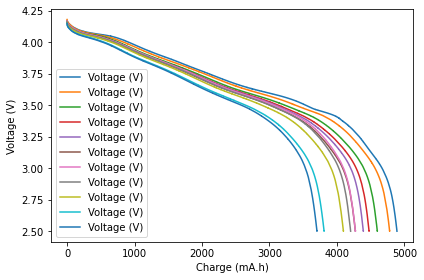

In [4]:
# Plot of the discharge voltage curves for the 3 datasets being analysed
fig_V_curves, ax = plt.subplots()
for cell in cellData_A:
    data_to_plot = cell[cell['Current (mA)'] < 0]
    data_to_plot.plot('Charge (mA.h)', 'Voltage (V)', ax=ax, )

ax.set_ylabel('Voltage (V)')

fig_V_curves.tight_layout()

In [5]:
# Mark Ruihe: define some new functions here:
# 1-Define a function to generate random numbers based on given values:
def Guess_0_Random(Num_try,guess_values_0,Min_guess_0,Max_guess_0):
    Min_guess = []; Max_guess =[]
    Guess_Values =[]
    for i in range(5):
        Min_guess.append( max(guess_values_0[i]*0.98,Min_guess_0[i])  )
        Max_guess.append( min(guess_values_0[i]*1.05,Max_guess_0[i])   ) 
    seed(1) # seed random number generator
    # generate random numbers between 0-1
    for k in range(Num_try):
        guess_values_i =[];
        for i in range(5):
            value = random()
            value_i =  Min_guess[i] + (value * (Max_guess[i] - Min_guess[i]))
            guess_values_i.append(value_i)
        Guess_Values.append(guess_values_i)
    return Guess_Values
# 2-Define a function to find the 8 min fits
# print(Err_1Cell1RPT_Alltries*1e3)
def Find_min(Err_1Cell1RPT_Alltries,Min_num):
    import copy
    Err_temp = copy.deepcopy(Err_1Cell1RPT_Alltries.tolist())
    min_number = []
    Min_index = []
    for _ in range(Min_num):
        number = min(Err_temp)
        i_temp = Err_temp.index(number)
        Err_temp[i_temp] = 1e6
        min_number.append(number)
        Min_index.append(i_temp)
        # print(number*1e3,i_temp)
    Err_temp = []
    return Min_index

In [6]:
# Do the actual OCV fit!
# Functions: Wrap OCV fit and plot things; output fit results and 8 best results
def Wrap_OCV_Fit(Cell_i_Dis_1RPT, Num_try, guess_values_0, 
    Min_guess_0, Max_guess_0,NE_Gr_OCV, NE_Si_OCV, PE_OCV):  
    
    Guess_Values = Guess_0_Random(Num_try,guess_values_0,Min_guess_0,Max_guess_0)
    Cell_i_Dis_1RPT = Cell_i_Dis_1RPT[
        Cell_i_Dis_1RPT[
        'Current (mA)']<0].loc[
        :, ['Charge (mA.h)', 'Voltage (V)']]
    Cell_i_Dis_1RPT.reset_index(inplace=True, drop=True)
    Cell_i_Dis_1RPT['SOC (%)'] =(
        1 - 
        Cell_i_Dis_1RPT['Charge (mA.h)']
        /Cell_i_Dis_1RPT['Charge (mA.h)'].max()   )
    z_1Cell1RPT_Alltries = []; Err_1Cell1RPT_Alltries=[]; Fit_1Cell1RPT_Alltries = [];
    for guess_values in Guess_Values:
        z_out, _, _ = dmc.stoich_OCV_fit_multi_comp(
            NE_Gr_OCV, NE_Si_OCV, PE_OCV, Cell_i_Dis_1RPT,
            z_guess=guess_values)
        Fit_1Cell1RPT, _, _, _ = dmc.calc_full_cell_OCV_multi_standalone(
            NE_Gr_OCV, NE_Si_OCV, PE_OCV, Cell_i_Dis_1RPT['SOC (%)'], 
            *z_out)
        fitted_Gr_fract = z_out[4].round(4)
        fitted_Si_fract = 1-fitted_Gr_fract
        err_BoL = dmc.DM_error_check(
            NE_Gr_OCV, NE_Si_OCV, PE_OCV, Cell_i_Dis_1RPT, 
            z_out)
        # print(f"RMSE for {guess_values} is {(err_BoL*1e3).round(2)} mV")
        # Append
        z_1Cell1RPT_Alltries.append(z_out); Err_1Cell1RPT_Alltries.append(err_BoL); 
        Fit_1Cell1RPT_Alltries.append(Fit_1Cell1RPT)
    Err_1Cell1RPT_Alltries = np.array(Err_1Cell1RPT_Alltries)    
    Min_index = Find_min(Err_1Cell1RPT_Alltries,8)
    # History: for 20 rounds of optimization, 64s is needed. 
    return z_1Cell1RPT_Alltries,Err_1Cell1RPT_Alltries,Fit_1Cell1RPT_Alltries,Min_index

# Global initial guess range - should be the same in at least one Exp set. 
#   PE_lo	NE_lo	PE_hi	NE_hi	Gr_frac
Min_guess_0 = [0.01, 0.001, 0.90, 0.80 , 0.70 ]; 
Max_guess_0 = [0.23, 0.05, 0.99, 0.95, 0.87]; 

str_cell = 'A'; RPT_num =  0
Cell_i_Dis_1RPT = eval("cellData_{}".format(str_cell))[RPT_num].copy() # This is where choose the cell and RPT
# inherit guess_value and select those closest. 
guess_values_0 = [0.1, 0.002, 0.95, 0.85, 0.84] # input values: 
Num_try = 20; 

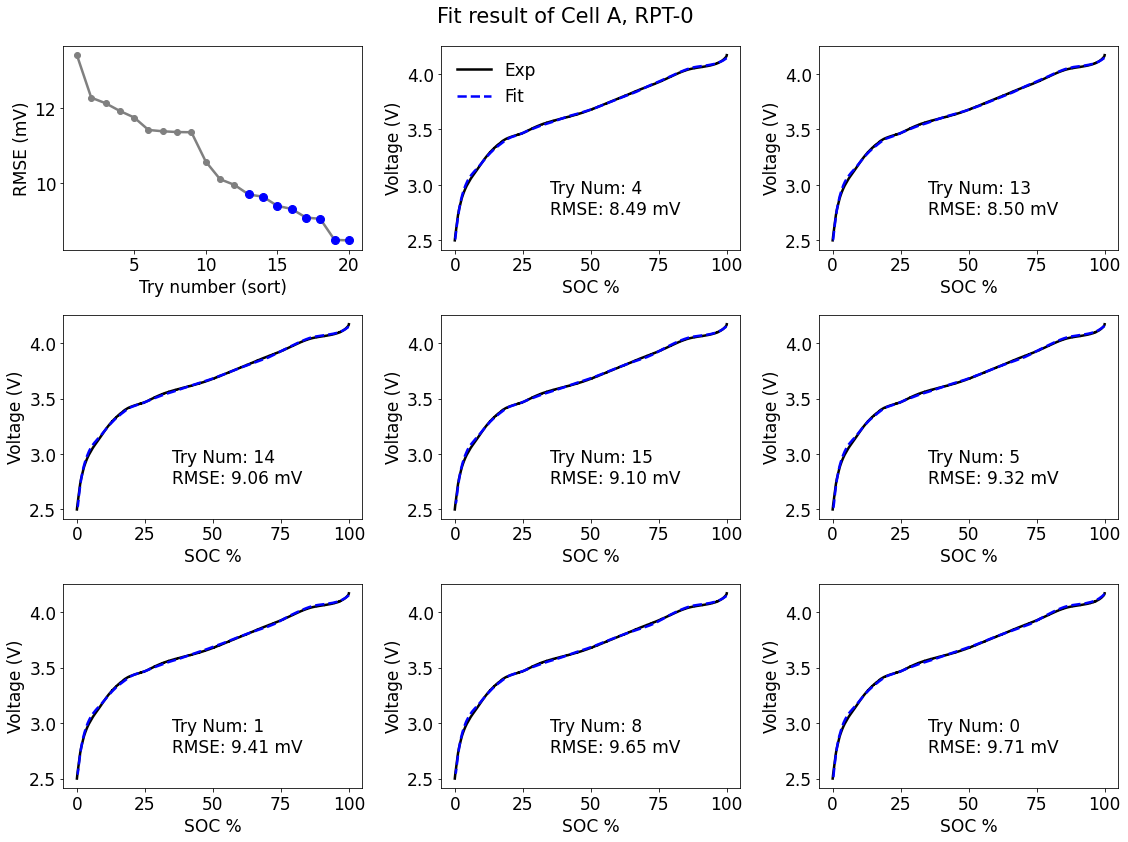

In [10]:
# plot 8 best results and select the most reasonable ones: 
import matplotlib as mpl; import copy; fs=17; lw=2.5; ms=6
font = {'family' : 'DejaVu Sans','size': fs}
mpl.rc('font', **font)
Index_Plot = {
    "0":[0,1],"1":[0,2],"2":[1,0],"3":[1,1],
    "4":[1,2],"5":[2,0],"6":[2,1],"7":[2,2] }

# Start a plot
Fig_DMA_1cell1RPT, ax = plt.subplots(3,3,  figsize=(16,12))
Err_1Cell1RPT_Alltries_temp = copy.deepcopy(Err_1Cell1RPT_Alltries)
Err_1Cell1RPT_Alltries_temp = abs( np.sort(-Err_1Cell1RPT_Alltries_temp)); 
Temp_List = np.arange(1,len(Err_1Cell1RPT_Alltries_temp)+1)
ax[0,0].plot(Temp_List,  Err_1Cell1RPT_Alltries_temp*1e3,  
    color='grey',linewidth=lw,  linestyle='-',marker = 'o',markersize = ms)
ax[0,0].plot(Temp_List[-8:] ,  Err_1Cell1RPT_Alltries_temp[-8:]*1e3,  
    color='b',linewidth=lw,  linestyle='none',marker = 'o',markersize = ms+2)
ax[0,0].set_ylabel('RMSE (mV)')
ax[0,0].set_xlabel('Try number (sort)')
# plot things:
for min_index,i in zip(Min_index,range(len(Min_index))):
    SOC_OCV_Temp = Fit_1Cell1RPT_Alltries[min_index].to_numpy()
    SOC_OCV_Exp  = Cell_i_Dis_1RPT.to_numpy()
    m,n = Index_Plot[str(i)]
    ax[m,n].plot(SOC_OCV_Exp[:,2]*100,SOC_OCV_Exp[:,1],linewidth=lw, ls='-',color='k',label='Exp', ) 
    ax[m,n].plot(SOC_OCV_Temp[:,0]*100,SOC_OCV_Temp[:,1],linewidth=lw, ls='--',color='b',label='Fit', ) 
    ax[m,n].set_xlabel('SOC %')
    ax[m,n].set_ylabel('Voltage (V)')
    ax[m,n].text(35,2.7,
        f'Try Num: {min_index}\nRMSE: {format(Err_1Cell1RPT_Alltries[min_index]*1e3,".2f")} mV',
        horizontalalignment='left',
        verticalalignment='bottom', fontsize=fs)
ax[0,1].legend(frameon=False,)

Fig_DMA_1cell1RPT.suptitle(
    f'Fit result of Cell {str_cell}, RPT-{RPT_num}', 
    fontsize=fs+4)
Fig_DMA_1cell1RPT.tight_layout()

In [8]:
# One figure for one RPT of one cell; therefore 9 cells; each cell has 13 RPT max; 
# total figure will be: 13*9=117 
# in each figure: sub-plot-1 for voltage fit for the best; 
#                 sub-plot-2 Dataset-number-RMSE
# another 3 plots same as Niall, but with one more plot for all voltage (best fit)
# functions to use: 
# 1-DM_calc_multi_comp_long             
# 2-stoich_OCV_fit_multi_comp 
# 3-calc_full_cell_OCV_multi_standalone 
# 4-DM_error_check (this round plus Niall's old version)
